## 1. 사용할 패키지 불러오기

In [1]:
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import json
from data_gen.data_gen import PointInferenceDatasetGenerator, ClassDatasetGenerator
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

/home/jongwook95.lee/miniforge3/envs/vision_machine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 데이터 불러오기

### (1) Inference Data 경로 지정

In [2]:
inference_img_path = './dataset/test/img'

### (2) Inference Data 불러오기

In [3]:
inference_img_list = os.listdir(inference_img_path)
inference_img_list = sorted(inference_img_list)
inference_img_list = [os.path.join(inference_img_path, img) for img in inference_img_list]

## 3. 모델링

In [4]:
save_path = 'cropped_image/inference'
os.makedirs(save_path, exist_ok=True)

### (1) Dataloader 생성

In [5]:
inference_dataset = PointInferenceDatasetGenerator(inference_img_list)
inference_dataloader = inference_dataset.dataloader()

### (2) 학습된 Point Prediction Model 불러오기

In [6]:
model_name = 'resnet18'
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 8)
vision_model.load_state_dict(torch.load('result/Best_model.pth'))

<All keys matched successfully>

### (3) Point 예측에 대한 Crop

In [29]:
print('Prediction')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in inference_dataloader['test']:
        images, width, height, original_image, fname = data['image'].float().to(device), data['width'].float(), data['height'].float(), data['original_image'].float(), data['fname']
        images = images.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.cpu().numpy()
        horizen_min = min(pred[0][0], pred[0][2], pred[0][4], pred[0][6])
        horizen_max = max(pred[0][0], pred[0][2], pred[0][4], pred[0][6])
        vertical_min = min(pred[0][1], pred[0][3], pred[0][5], pred[0][7])
        vertical_max = max(pred[0][1], pred[0][3], pred[0][5], pred[0][7])
        horizen_min = int(horizen_min / 448 * height)
        horizen_max = int(horizen_max / 448 * height)
        vertical_min = int(vertical_min / 224 * width)
        vertical_max = int(vertical_max / 224 * width)
        cropped_image = np.array(original_image)[0, :, :, :][vertical_min:vertical_max, horizen_min:horizen_max, :]
        save_fname = os.path.join(save_path, fname[0])
        cv2.imwrite(save_fname, cropped_image)





Prediction


### (4) 학습된 Class Prediction Model 불러오기

In [30]:
model_name = 'resnet18'
vision_model = models.resnet18(pretrained=True)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, len(uni_label))

### (5) 학습

In [31]:
print("{} start training!".format(model_name))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vision_model.to(device)
min_valid_loss = np.inf


for e in range(epoch):
    train_loss = 0.0
    correct = 0
    total = 0
    vision_model.train()     # Optional when not using Model Specific layer
    for data in train_dataloader['train']:
        if torch.cuda.is_available():
            images, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        optimizer.zero_grad()
        target = vision_model(images)
        loss = loss_fn(target,torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(target, 1)
        correct += (predicted == torch.argmax(labels, dim=1)).float().sum()
        total += labels.size(0)
            
    train_acc = correct / total
    correct = 0
    total = 0
    valid_loss = 0.0
    vision_model.eval()     # Optional when not using Model Specific layer
    for data in test_dataloader['test']:
        if torch.cuda.is_available():
            data, labels = data['image'].float().to(device), data['target'].float().to(device)
        
        target = vision_model(data)
        loss = loss_fn(target,torch.argmax(labels, dim=1))
        valid_loss = loss.item() * data.size(0)
        _, predicted = torch.max(target, 1)
        correct += (predicted == torch.argmax(labels, dim=1)).float().sum()
        total += labels.size(0)
    valid_acc = correct / total

    print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Training Acc: {train_acc} \t\t Test Loss: {valid_loss / len(test_dataloader)} \t Test Acc: {valid_acc}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(vision_model.state_dict(), result_dir + 'Classification_Best_model.pth')

resnet18 start training!


KeyboardInterrupt: 

### (6) Load Best Model

In [33]:
vision_model.load_state_dict(torch.load('result/Classification_Best_model.pth'))

<All keys matched successfully>

### (7) 성능 평가

In [34]:
print('Test Prediction')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = []
vision_model.to(device)

with torch.no_grad():  
    for data in test_dataloader['test']:
        images, labels = data['image'].float().to(device), data['target'].float().to(device)
        images = images.to(device)  
        labels = labels.to(device)  
        vision_model.eval()  
        yhat = vision_model(images)  
        pred = yhat.argmax(dim=1, keepdim = False)
        pred = list(pred.cpu().numpy())
        predictions = predictions + pred

Test Prediction


Text(0.5, 1.0, 'Confusion_matrix')

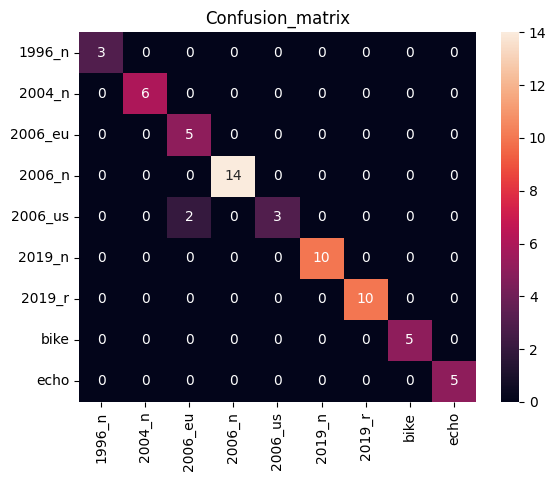

In [35]:
ground_truth = np.argmax(test_target_list, axis=-1)
distribution = confusion_matrix(ground_truth, predictions)
plt.figure()
distribution = pd.DataFrame(distribution, index=uni_label, columns=uni_label)
ax = sns.heatmap(distribution, annot=True)
plt.title('Confusion_matrix')

In [36]:
from sklearn.metrics import accuracy_score, f1_score
print("Test Accuracy: {}".format(accuracy_score(ground_truth, predictions)))

Test Accuracy: 0.9682539682539683
